In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading Data

In [2]:
epsilon_pimu = 1/100


modes_dt = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
            1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
            2: {'mode': './features/DsstarTauNu_10Noise.root', 'yields': 7.90e5}, 
            3: {'mode': './features/DsstarMuNu_10Noise.root', 'yields': 1.84e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
           }


In [3]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df()    
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [4]:
tr_te_split = 1
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# df_test, df_train = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

train size: 99609 (100.00%); test size: 0 (0.00%)
data points per mode:  [1564, 10261, 845, 2681, 2374, 7623, 74261]


In [5]:
df_tau = df_train[df_train.target==2]
df_mu = df_train[df_train.target==3]

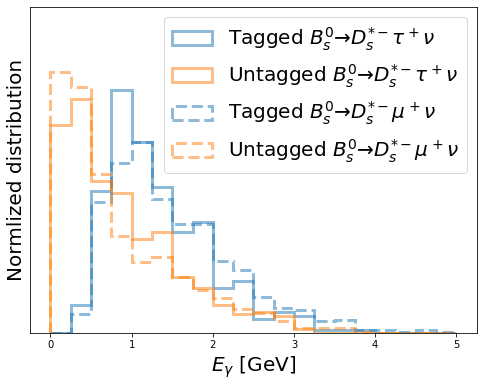

In [33]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0, 5]
bins_ = 20

ax1.margins(y=0.25)


ax1.hist(df_tau[df_tau.isDsPho==1]['EPhoTrue'], weights=[1/len(df_tau[df_tau.isDsPho==1])] * len(df_tau[df_tau.isDsPho==1]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Tagged $B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_tau[df_tau.isDsPho==0]['EPhoTrue'], weights=[1/len(df_tau[df_tau.isDsPho==0])] * len(df_tau[df_tau.isDsPho==0]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Untagged $B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_mu[df_mu.isDsPho==1]['EPhoTrue'], weights=[1/len(df_mu[df_mu.isDsPho==1])] * len(df_mu[df_mu.isDsPho==1]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Tagged $B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_mu[df_mu.isDsPho==0]['EPhoTrue'], weights=[1/len(df_mu[df_mu.isDsPho==0])] * len(df_mu[df_mu.isDsPho==0]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Untagged $B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E_\gamma$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
# ax1.axvline(c3, color='red', lw=3)

f.savefig('./figures/Dsstar_photonTag')

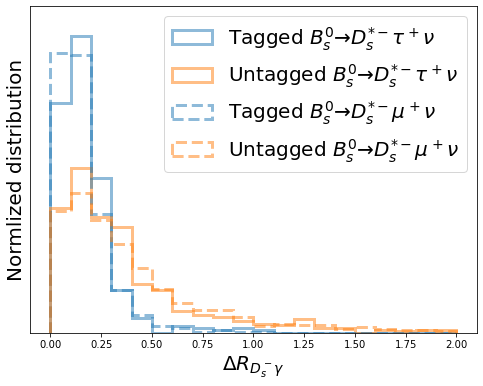

In [34]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0, 2]
bins_ = 20

ax1.margins(y=0.1)


ax1.hist(df_tau[df_tau.isDsPho==1]['DeltaRDsPhoTrue'], weights=[1/len(df_tau[df_tau.isDsPho==1])] * len(df_tau[df_tau.isDsPho==1]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Tagged $B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_tau[df_tau.isDsPho==0]['DeltaRDsPhoTrue'], weights=[1/len(df_tau[df_tau.isDsPho==0])] * len(df_tau[df_tau.isDsPho==0]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Untagged $B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_mu[df_mu.isDsPho==1]['DeltaRDsPhoTrue'], weights=[1/len(df_mu[df_mu.isDsPho==1])] * len(df_mu[df_mu.isDsPho==1]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Tagged $B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_mu[df_mu.isDsPho==0]['DeltaRDsPhoTrue'], weights=[1/len(df_mu[df_mu.isDsPho==0])] * len(df_mu[df_mu.isDsPho==0]), bins=bins_, range=range_, histtype='step', lw=3, label=r'Untagged $B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\Delta R_{D_s^-\gamma}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
# ax1.axvline(c3, color='red', lw=3)

f.savefig('./figures/Dsstar_angularsep_2')

In [8]:
df_tau.correctPhoton.sum()/len(df_tau)

0.3680473372781065

In [9]:
df_mu.correctPhoton.sum()/len(df_mu)

0.39201790376725104

In [35]:
epsilon_pimu = 1/100


modes_dt = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
            1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
            2: {'mode': './features/DsstarTauNu_10Noise.root', 'yields': 7.90e5}, 
            3: {'mode': './features/DsstarMuNu_10Noise.root', 'yields': 1.84e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
           }


modes_dt0 = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
            1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
            2: {'mode': './features/DsstarTauNu_10Noise_0Alpha.root', 'yields': 7.90e5}, 
            3: {'mode': './features/DsstarMuNu_10Noise_0Alpha.root', 'yields': 1.84e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
           }

modes_dt01 = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
            1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
            2: {'mode': './features/DsstarTauNu_10Noise_01Alpha.root', 'yields': 7.90e5}, 
            3: {'mode': './features/DsstarMuNu_10Noise_01Alpha.root', 'yields': 1.84e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
           }

modes_dt05 = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
            1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
            2: {'mode': './features/DsstarTauNu_10Noise_05Alpha.root', 'yields': 7.90e5}, 
            3: {'mode': './features/DsstarMuNu_10Noise_05Alpha.root', 'yields': 1.84e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
           }

modes_dt2 = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
            1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
            2: {'mode': './features/DsstarTauNu_10Noise_2Alpha.root', 'yields': 7.90e5}, 
            3: {'mode': './features/DsstarMuNu_10Noise_2Alpha.root', 'yields': 1.84e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
           }


In [36]:

df_train0, df_test0 = load_train_test(modes_dt0, tr_te_split)
df_train01, df_test01 = load_train_test(modes_dt01, tr_te_split)
df_train05, df_test05 = load_train_test(modes_dt05, tr_te_split)
df_train2, df_test2 = load_train_test(modes_dt2, tr_te_split)

train size: 99609 (100.00%); test size: 0 (0.00%)
data points per mode:  [1564, 10261, 845, 2681, 2374, 7623, 74261]
train size: 99609 (100.00%); test size: 0 (0.00%)
data points per mode:  [1564, 10261, 845, 2681, 2374, 7623, 74261]
train size: 99609 (100.00%); test size: 0 (0.00%)
data points per mode:  [1564, 10261, 845, 2681, 2374, 7623, 74261]
train size: 99609 (100.00%); test size: 0 (0.00%)
data points per mode:  [1564, 10261, 845, 2681, 2374, 7623, 74261]


In [37]:
df_tau0 = df_train0[df_train0.target==2]
df_mu0 = df_train0[df_train0.target==3]

df_tau01 = df_train01[df_train01.target==2]
df_mu01 = df_train01[df_train01.target==3]

df_tau05 = df_train05[df_train05.target==2]
df_mu05 = df_train05[df_train05.target==3]

df_tau2 = df_train2[df_train2.target==2]
df_mu2 = df_train2[df_train2.target==3]


In [38]:
print("{:.4f}\n{:.4f}\n{:.4f}\n{:.4f}\n{:.4f}\n".format(
df_tau0.correctPhoton.sum()/len(df_tau0), \
df_tau01.correctPhoton.sum()/len(df_tau01), \
df_tau05.correctPhoton.sum()/len(df_tau05), \
df_tau.correctPhoton.sum()/len(df_tau), \
df_tau2.correctPhoton.sum()/len(df_tau2)))


0.3905
0.3858
0.3775
0.3680
0.3503



In [39]:
print("{:.4f}\n{:.4f}\n{:.4f}\n{:.4f}\n{:.4f}\n".format(
df_mu0.correctPhoton.sum()/len(df_mu0), \
df_mu01.correctPhoton.sum()/len(df_mu01), \
df_mu05.correctPhoton.sum()/len(df_mu05), \
df_mu.correctPhoton.sum()/len(df_mu), \
df_mu2.correctPhoton.sum()/len(df_mu2)))


0.4077
0.4062
0.3995
0.3920
0.3764



In [40]:
# alpha   photon tag eff.
# tau:
# 0.3905
# 0.3858
# 0.3775
# 0.3680
# 0.3503

# mu:
# 0.4077
# 0.4062
# 0.3995
# 0.3920
# 0.3764

In [41]:
df_train_ = df_train[(df_train.target<=3)]
df_train2_ = df_train2[(df_train2.target<=3)]
df_train05_ = df_train05[(df_train05.target<=3)]
df_train01_ = df_train05[(df_train01.target<=3)]
df_train0_ = df_train05[(df_train0.target<=3)]

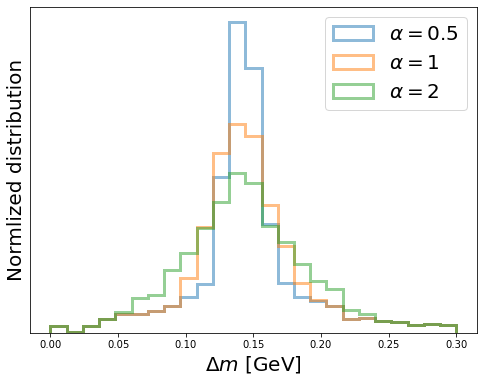

In [42]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0, 0.3]
bins_ = 25

# ax1.hist(df_train01_['DeltaM'], weights=df_train01_['weight']/(df_train01_['weight'].sum()), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\alpha=0.5$', alpha=0.5);
ax1.hist(df_train05_['DeltaM'], weights=df_train05_['weight']/(df_train05_['weight'].sum()), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\alpha=0.5$', alpha=0.5);
ax1.hist(df_train_['DeltaM'], weights=df_train_['weight']/(df_train_['weight'].sum()), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\alpha=1$', alpha=0.5);
ax1.hist(df_train2_['DeltaM'], weights=df_train2_['weight']/(df_train2_['weight'].sum()), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\alpha=2$', alpha=0.5);


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\Delta m$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsdeltam_alphas')
